In [12]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

## STEP 1 : 데이터 구성하기

In [13]:
df_raw = pd.read_csv("/home/piai/Downloads/환율.csv", engine="python", parse_dates = ["APPL_DATE"])
df_raw.head()

,CURRENCY,APPL_DATE,STD_RATE,USD_CONV_DATE
0,CNY,2016-01-01,181.48,0.1541
1,JPY,2016-01-01,976.99,0.8294
2,USD,2016-01-01,1178.00,1.0000
3,CNY,2016-01-02,181.48,0.1541
4,JPY,2016-01-02,976.99,0.8294


In [14]:
# STD_RATE(standard rate): 매매기준율

In [15]:
df_raw_pivot = df_raw.pivot(index = "APPL_DATE", columns = "CURRENCY", values= "STD_RATE")
df_raw_pivot.head()

CURRENCY,CNY,JPY,USD
APPL_DATE,,,
2016-01-01,181.48,976.99,1178.0
2016-01-02,181.48,976.99,1178.0
2016-01-03,181.48,976.99,1178.0
2016-01-04,181.10,992.62,1184.0
2016-01-05,181.94,993.00,1185.0


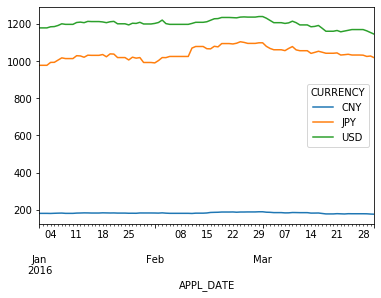

In [17]:
df_raw_pivot.plot()

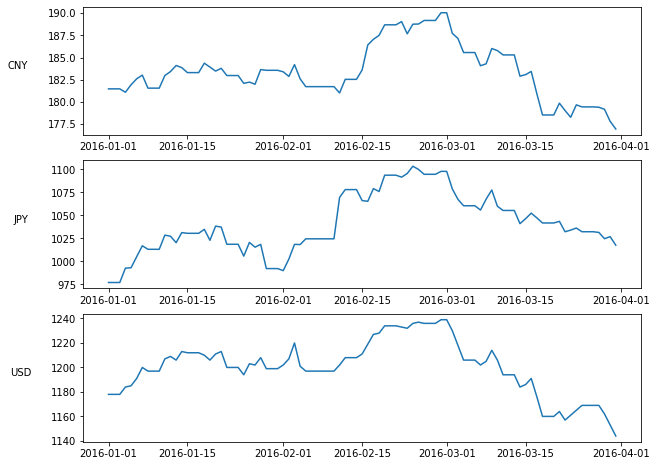

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1, figsize = (10,8))

for(ax, idx, currency) in zip([ax1, ax2, ax3], [311,312,313],["CNY","JPY","USD"]):
    ax.plot("APPL_DATE", "STD_RATE", data = df_raw[df_raw["CURRENCY"]==currency])
    
    ax.set_ylabel(currency, rotation = 0, labelpad = 30)

In [18]:
# 비정상성을 보이고 있다. => 차분이 필요하다!

In [19]:
df_CNY = df_raw[df_raw["CURRENCY"] == "CNY"].set_index("APPL_DATE")
df_CNY.drop(["CURRENCY", "USD_CONV_DATE"], axis = 1, inplace = True)

df_JPY = df_raw[df_raw["CURRENCY"] == "JPY"].set_index("APPL_DATE")
df_JPY.drop(["CURRENCY", "USD_CONV_DATE"], axis = 1, inplace = True)

df_USD = df_raw[df_raw["CURRENCY"] == "USD"].set_index("APPL_DATE")
df_USD.drop(["CURRENCY", "USD_CONV_DATE"], axis = 1, inplace = True)

In [20]:
df_CNY.head()

,STD_RATE
APPL_DATE,
2016-01-01,181.48
2016-01-02,181.48
2016-01-03,181.48
2016-01-04,181.10
2016-01-05,181.94


In [22]:
train_size = 0.9
len_idx = len(df_CNY.index)
mask = (np.arange(len_idx) / len_idx)< train_size
mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False])

In [23]:
df_CNY_train = df_CNY[mask]
df_CNY_test = df_CNY[~mask]
print("shape of train data: {}".format(df_CNY_train.shape))
print("shape of test data: {}".format(df_CNY_test.shape))

shape of train data: (82, 1)
shape of test data: (9, 1)


In [24]:
df_CNY_train = df_CNY[df_CNY.index <= "2016-03-22"]
df_CNY_test = df_CNY[df_CNY.index > "2016-03-22"]
df_CNY_test

,STD_RATE
APPL_DATE,
2016-03-23,178.28
2016-03-24,179.68
2016-03-25,179.45
2016-03-26,179.45
2016-03-27,179.45
2016-03-28,179.41
2016-03-29,179.18
2016-03-30,177.83
2016-03-31,176.96


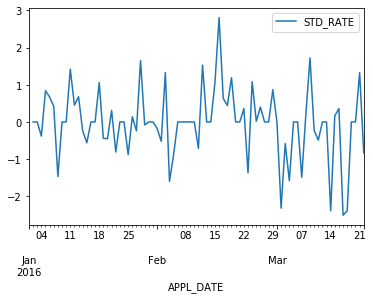

In [25]:
# 1차 차분
df_CNY_diff1 = df_CNY_train - df_CNY_train.shift(1)
df_CNY_diff1.plot()

#### -> 정상성 만족 x

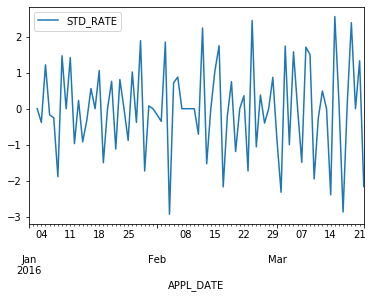

In [26]:
# 2차 차분
df_CNY_diff2 = df_CNY_train - 2 * (df_CNY_train.shift(1)) + (df_CNY_train.shift(2))
df_CNY_diff2.plot()

#### -> 2차 차분으로 시간에 따른 경향성을 가지지 않는 정상성을 만족

## 자기 상관 함수 및 부분 자기상관 함수

Lag 를 30까지 해서 ACF, PACF 산출

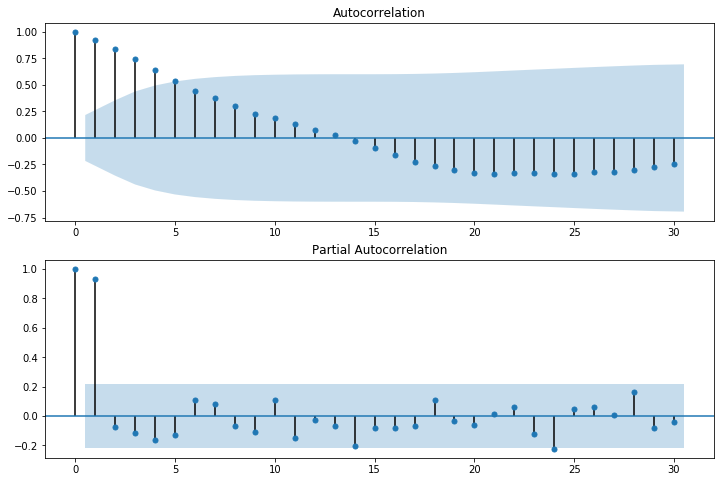

In [27]:
lag_size = 30
fig = plt.figure(figsize =(12,8))

ax1 = fig.add_subplot(211)
fig = plot_acf(df_CNY_train["STD_RATE"], lags=lag_size, ax=ax1)

ax2 = fig.add_subplot(212)
fig = plot_pacf(df_CNY_train["STD_RATE"], lags=lag_size, ax=ax2)

- ACF는 지속적으로 감소하고 p=13 시점에서 양에서 음으로 변함
- PACF는 p=1 시점에서 0.9보다 크고 이후 급격히 감소(절단면)함
- 따라서 p=1, q=0 모델이 적당하다고 판단 -> ARMA(1,0)

## 시계열 모델

In [28]:
ts_model_cny = ARIMA(df_CNY_train, order = (1,2,0))

ts_result_cny = ts_model_cny.fit(trend = "c", full_output = True)
print(ts_result_cny.summary())

                             ARIMA Model Results                              
Dep. Variable:            D2.STD_RATE   No. Observations:                   80
Model:                 ARIMA(1, 2, 0)   Log Likelihood                -123.512
Method:                       css-mle   S.D. of innovations              1.132
Date:                Wed, 08 Jul 2020   AIC                            253.025
Time:                        17:22:27   BIC                            260.171
Sample:                    01-03-2016   HQIC                           255.890
                         - 03-22-2016                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0022      0.088     -0.024      0.981      -0.175       0.171
ar.L1.D2.STD_RATE    -0.4389      0.102     -4.322      0.000      -0.638      -0.240
                        

/home/piai/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/piai/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


- AIC가 적어질수록 더 좋은 모델. 비교하여 AIC가 좋은 것을 택하면 됨.

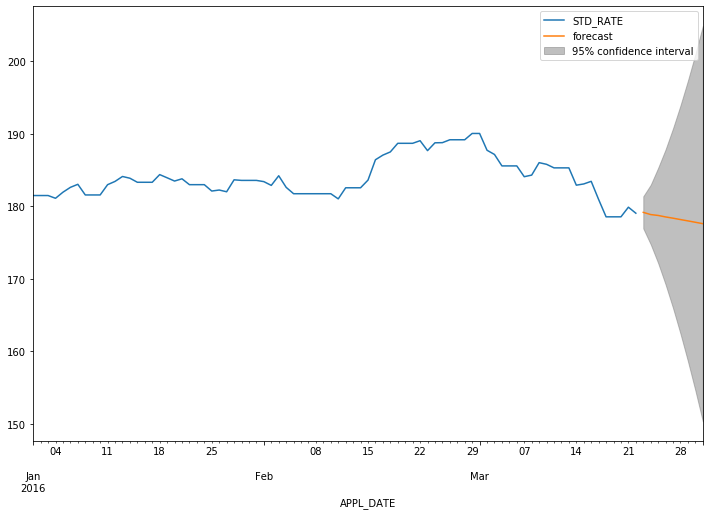

In [29]:
start_time = df_CNY_test.index.min()
end_time = df_CNY_test.index.max()
fig, ax = plt.subplots(figsize = (12,8))

ax = df_CNY_train.plot(ax = ax)

fig = ts_result_cny.plot_predict(start = start_time, end=end_time, ax = ax, plot_insample=False)

In [31]:
start_time = pd.to_datetime("2016-01-03")
y_pred = ts_result_cny.predict(start=start_time, end = end_time, typ = 'levels')

df_merge = df_CNY

df_merge["예측값"] = y_pred
df_merge.head().round(2)

,STD_RATE,예측값
APPL_DATE,,
2016-01-01,181.48,NaN
2016-01-02,181.48,NaN
2016-01-03,181.48,181.48
2016-01-04,181.10,181.48
2016-01-05,181.94,180.88


/home/piai/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 50696 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/piai/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 52769 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/piai/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 44050 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/piai/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 50696 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/piai/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 52769 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/piai/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWar

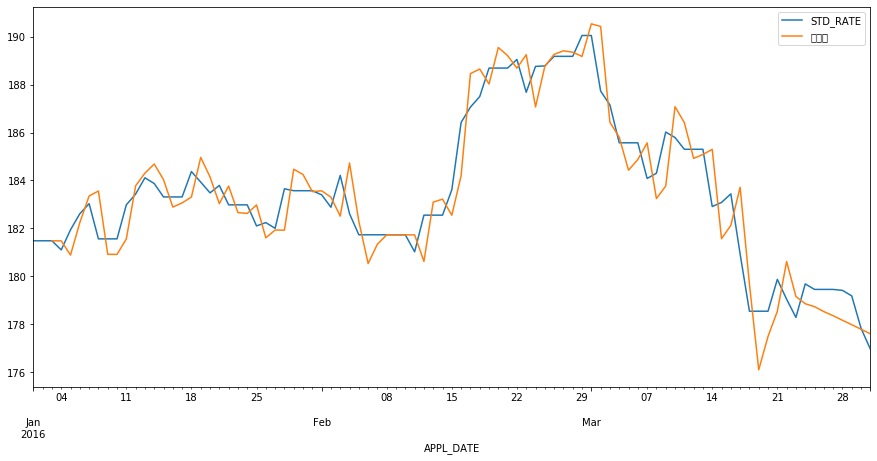

In [32]:
df_merge.plot(y = ["STD_RATE","예측값"], figsize=(15,7))